# Introduction

Titanic disaster in one of the deadliest disasters in history. Among more than 2,000 passengers and crew aboard, more than 1,500 people died. If you have watched the movie "Titanic", you may be familiar with the disater.
There are not enought lifeboats aboard, which causes the huge amount of death. Therefore, being in the lifeboats is the key to survive. In the movie, people tend to send women and children to lifeboats and let them survive, but is it true in the real life? The purpose of this project is to predict who will survive in this disaster.

## Data

The dataset can be found [here](https://www.kaggle.com/c/titanic/data), including:

* training set (train.csv)
* test set (test.csv)

### Features

* pclass - Ticket class (1 = Upper, 2 = Middle, 3 = Lower)
* sex - Sex	
* Age - in years (fractional if less than 1. If the age is estimated, is it in the form of xx.5)
* sibsp	- # of siblings / spouses aboard the Titanic	
  * sibling - brother, sister, stepbrother, stepsister
  * spouses - husband, wife (mistresses and fianc√©s were ignored)
* parch	- # of parents / children aboard the Titanic	
* ticket - Ticket number	
* fare - Passenger fare	
* cabin - Cabin number	
* embarked - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

### Label

* survival - Survival (0 = No, 1 = Yes)

# Getting Started

To begin working with the data, we need to first install all the necessary modules, and then load the data into a pandas DataFrame

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [116]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Explore the dataset

Let's explore this dataset a little bit, and find some interesting facts that could help with the prediction. 

## Overall Dataset

In [50]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Single Variable

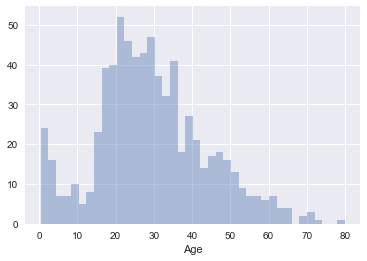

In [52]:
sns.distplot(train['Age'].dropna(), kde=False, bins=40)

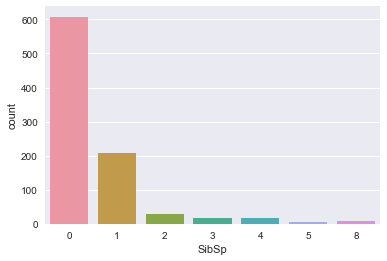

In [53]:
sns.countplot(data=train, x='SibSp')

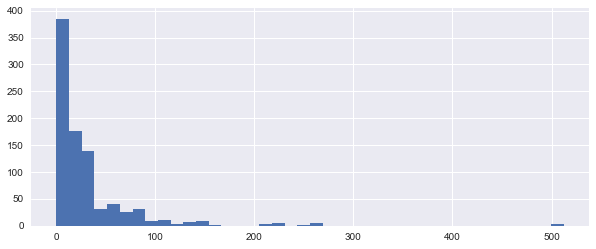

In [54]:
train['Fare'].hist(bins=40,figsize=(10, 4))

## Multiple Variables

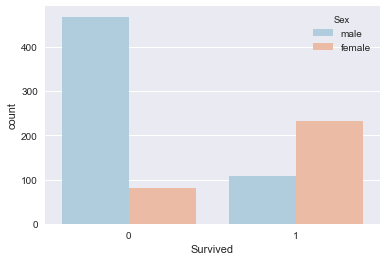

In [55]:
sns.countplot(data=train, x='Survived', hue='Sex', palette='RdBu_r')

Based on this plot, females are more likely to survive than male.

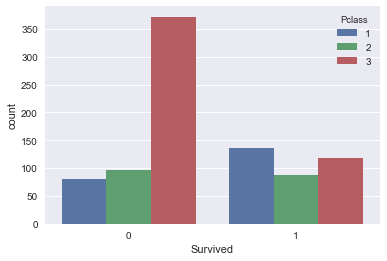

In [56]:
sns.countplot(data=train, x='Survived', hue='Pclass')

Based on thsi plot, Upper and Middle class passengers are more likely to survive.

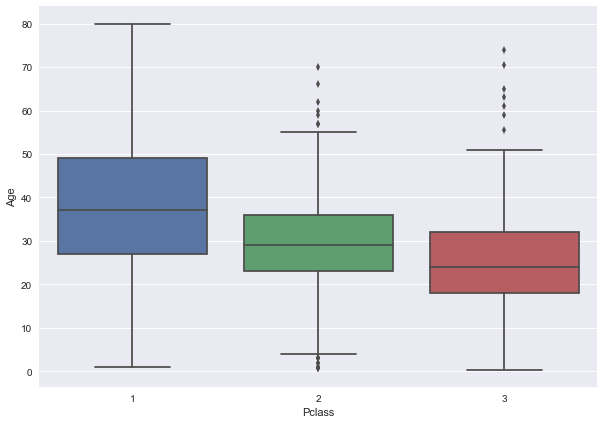

In [57]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=train, x='Pclass', y='Age')

It seems that Upper class customer is generally older than Middle class and Lower class.

# Wrangle the dataset

## Missing Information

There are a lot of missing information in this dataset. Before diving into building up the models, we need to clean up the missing information

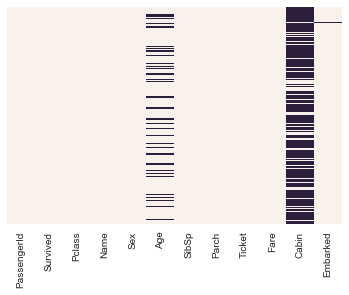

In [58]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False)

It seems that there are little information missing on `Embarked`column, some information missing on `Age` column, and a lot of information missing on `Cabin` column.

### Impute Age variable

Age can be very helpful in the prediction, therefore, we need to find a way to fill those missing information. From the previous exploration, we can see that average ages are different among different classes. We can seperate passengers by their class, and fill in the missing age by the average age per class.

In [117]:
def impute_age_train(cols):
    age = cols[0]
    pclass = cols[1]
    
    if pd.isnull(age):
        if pclass == 1:
            return np.mean(train[train['Pclass'] == 1]['Age'])
        elif pclass == 2:
            return np.mean(train[train['Pclass'] == 2]['Age'])
        else:
            return np.mean(train[train['Pclass'] == 3]['Age'])
    else:
        return age

In [118]:
def impute_age_test(cols):
    age = cols[0]
    pclass = cols[1]
    
    if pd.isnull(age):
        if pclass == 1:
            return np.mean(test[test['Pclass'] == 1]['Age'])
        elif pclass == 2:
            return np.mean(test[test['Pclass'] == 2]['Age'])
        else:
            return np.mean(test[test['Pclass'] == 3]['Age'])
    else:
        return age

In [119]:
train['Age'] = train[['Age', 'Pclass']].apply(impute_age_train, axis=1)
test['Age'] = test[['Age', 'Pclass']].apply(impute_age_test, axis=1)

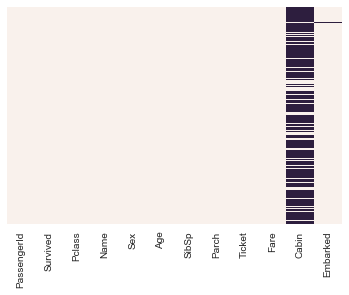

In [120]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False)

### Drop the Cabin Variable

There are too much information missing for `Cabin` column. It is a better idea to drop it than manipulate it.

In [121]:
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

### Drop the rest missing rows

There are not much information now. We can safely drop the few rows with missing information.

In [122]:
train.dropna(inplace=True)

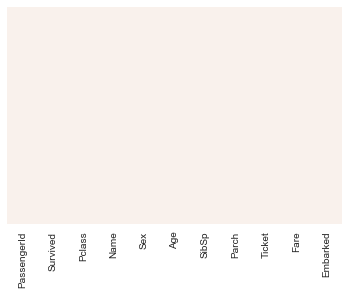

In [123]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False)

## Catogorical Variables

There are some columns like `Sex` has values of `male` and `female`. Machine Learning algorithms does not know what to do with these strings. Therefore, we need to transform into a dummy variable format for analysis.

In [124]:
sex_train = pd.get_dummies(train['Sex'], drop_first=True)
sex_test = pd.get_dummies(test['Sex'], drop_first=True)

In [125]:
embark_train = pd.get_dummies(train['Embarked'], drop_first=True)
embark_test = pd.get_dummies(test['Embarked'], drop_first=True)

In [126]:
train = pd.concat([train, sex_train, embark_train], axis=1)
test = pd.concat([test, sex_test, embark_test], axis=1)
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Embarked  male  Q  S  
0      0         A/5 21171   7.2500        S     1  0  1  
1      0          PC 17599  71.2833        C     0  0  0  
2      0  STON/O2. 3101282   7.9250        S     0  0  1  
3      0            113803  53.1000        S     0  0  1  
4      0            373450   8.0500        S     1  0  1

## Drop unused Columns

In [127]:
train.drop(['Sex', 'Name', 'Embarked', 'Ticket'], axis=1, inplace=True)
test.drop(['Sex', 'Name', 'Embarked', 'Ticket'], axis=1, inplace=True)
train.head()

PassengerId  Survived  Pclass   Age  SibSp  Parch     Fare  male  Q  S
0            1         0       3  22.0      1      0   7.2500     1  0  1
1            2         1       1  38.0      1      0  71.2833     0  0  0
2            3         1       3  26.0      0      0   7.9250     0  0  1
3            4         1       1  35.0      1      0  53.1000     0  0  1
4            5         0       3  35.0      0      0   8.0500     1  0  1

In [128]:
train.drop(['PassengerId'], axis=1, inplace=True)
train.head()

Survived  Pclass   Age  SibSp  Parch     Fare  male  Q  S
0         0       3  22.0      1      0   7.2500     1  0  1
1         1       1  38.0      1      0  71.2833     0  0  0
2         1       3  26.0      0      0   7.9250     0  0  1
3         1       1  35.0      1      0  53.1000     0  0  1
4         0       3  35.0      0      0   8.0500     1  0  1

In [129]:
train.reset_index(drop=True, inplace=True)
train.head()

Survived  Pclass   Age  SibSp  Parch     Fare  male  Q  S
0         0       3  22.0      1      0   7.2500     1  0  1
1         1       1  38.0      1      0  71.2833     0  0  0
2         1       3  26.0      0      0   7.9250     0  0  1
3         1       1  35.0      1      0  53.1000     0  0  1
4         0       3  35.0      0      0   8.0500     1  0  1

# Machine Learning Models

After clearning up the dataset, it is time to train various machine learning algorithms and find the best model. Since the test dataset has to upload to be evaludated, to choose the best model for the predict the testset, I will use cross-validation select the best model.

## Pre-processing

In [25]:
features = train.drop('Survived', axis=1)
labels = train['Survived']

In [26]:
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.3, random_state=106)

In [27]:
%run cross_validation.py

## Naive Bayes

In [28]:
params = {'priors': [None]}
grid = GridSearchCV(GaussianNB(), param_grid=params, cv=cv, verbose=3, scoring='accuracy')
grid.fit(features, labels)
nb = grid.best_estimator_

Fitting 100 folds for each of 1 candidates, totalling 100 fits
[CV] priors=None .....................................................
[CV] ...................... priors=None, score=0.812734, total=   0.0s
[CV] priors=None .....................................................
[CV] ...................... priors=None, score=0.820225, total=   0.0s
[CV] priors=None .....................................................
[CV] ...................... priors=None, score=0.790262, total=   0.0s
[CV] priors=None .....................................................
[CV] ...................... priors=None, score=0.745318, total=   0.0s
[CV] priors=None .....................................................
[CV] ...................... priors=None, score=0.801498, total=   0.0s
[CV] priors=None .....................................................
[CV] ...................... priors=None, score=0.749064, total=   0.0s
[CV] priors=None .....................................................
[CV] .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... priors=None, score=0.775281, total=   0.0s
[CV] priors=None .....................................................
[CV] ...................... priors=None, score=0.794007, total=   0.0s
[CV] priors=None .....................................................
[CV] ...................... priors=None, score=0.767790, total=   0.0s
[CV] priors=None .....................................................
[CV] ...................... priors=None, score=0.775281, total=   0.0s
[CV] priors=None .....................................................
[CV] ...................... priors=None, score=0.764045, total=   0.0s
[CV] priors=None .....................................................
[CV] ...................... priors=None, score=0.779026, total=   0.0s
[CV] priors=None .....................................................
[CV] ...................... priors=None, score=0.805243, total=   0.0s
[CV] priors=None .....................................................
[CV] .

[CV] ...................... priors=None, score=0.767790, total=   0.0s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [29]:
cross_validation(nb, features, labels)

accuracy: 0.7865168539325843
precision: 0.7027027027027027 
recall: 0.7647058823529411
f1: 0.7323943661971832


## Logistic Regression

In [30]:
params = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 5, 10, 100]}
grid = GridSearchCV(LogisticRegression(), param_grid = params, cv=cv, 
                    verbose=3, scoring='accuracy')
grid.fit(features, labels)
logistic = grid.best_estimator_

Fitting 100 folds for each of 12 candidates, totalling 1200 fits
[CV] penalty=l1, C=0.01 ..............................................
[CV] ............... penalty=l1, C=0.01, score=0.674157, total=   0.0s
[CV] penalty=l1, C=0.01 ..............................................
[CV] ............... penalty=l1, C=0.01, score=0.681648, total=   0.0s
[CV] penalty=l1, C=0.01 ..............................................
[CV] ............... penalty=l1, C=0.01, score=0.681648, total=   0.0s
[CV] penalty=l1, C=0.01 ..............................................
[CV] ............... penalty=l1, C=0.01, score=0.625468, total=   0.0s
[CV] penalty=l1, C=0.01 ..............................................
[CV] ............... penalty=l1, C=0.01, score=0.689139, total=   0.0s
[CV] penalty=l1, C=0.01 ..............................................
[CV] ............... penalty=l1, C=0.01, score=0.659176, total=   0.0s
[CV] penalty=l1, C=0.01 ..............................................
[CV] .......

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ............... penalty=l1, C=0.01, score=0.681648, total=   0.0s
[CV] penalty=l1, C=0.01 ..............................................
[CV] ............... penalty=l1, C=0.01, score=0.696629, total=   0.0s
[CV] penalty=l1, C=0.01 ..............................................
[CV] ............... penalty=l1, C=0.01, score=0.647940, total=   0.0s
[CV] penalty=l1, C=0.01 ..............................................
[CV] ............... penalty=l1, C=0.01, score=0.677903, total=   0.0s
[CV] penalty=l1, C=0.01 ..............................................
[CV] ............... penalty=l1, C=0.01, score=0.689139, total=   0.0s
[CV] penalty=l1, C=0.01 ..............................................
[CV] ............... penalty=l1, C=0.01, score=0.662921, total=   0.0s
[CV] penalty=l1, C=0.01 ..............................................
[CV] ............... penalty=l1, C=0.01, score=0.681648, total=   0.0s
[CV] penalty=l1, C=0.01 ..............................................
[CV] .

[CV] ............... penalty=l2, C=0.01, score=0.670412, total=   0.0s
[CV] penalty=l2, C=0.01 ..............................................
[CV] ............... penalty=l2, C=0.01, score=0.707865, total=   0.0s
[CV] penalty=l2, C=0.01 ..............................................
[CV] ............... penalty=l2, C=0.01, score=0.707865, total=   0.0s
[CV] penalty=l2, C=0.01 ..............................................
[CV] ............... penalty=l2, C=0.01, score=0.719101, total=   0.0s
[CV] penalty=l2, C=0.01 ..............................................
[CV] ............... penalty=l2, C=0.01, score=0.719101, total=   0.0s
[CV] penalty=l2, C=0.01 ..............................................
[CV] ............... penalty=l2, C=0.01, score=0.707865, total=   0.0s
[CV] penalty=l2, C=0.01 ..............................................
[CV] ............... penalty=l2, C=0.01, score=0.696629, total=   0.0s
[CV] penalty=l2, C=0.01 ..............................................
[CV] .

[CV] ................ penalty=l1, C=0.1, score=0.827715, total=   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................ penalty=l1, C=0.1, score=0.767790, total=   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................ penalty=l1, C=0.1, score=0.782772, total=   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................ penalty=l1, C=0.1, score=0.767790, total=   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................ penalty=l1, C=0.1, score=0.831461, total=   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................ penalty=l1, C=0.1, score=0.782772, total=   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................ penalty=l1, C=0.1, score=0.767790, total=   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] .

[CV] ................ penalty=l2, C=0.1, score=0.797753, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.801498, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.782772, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.820225, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.823970, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.812734, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.771536, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] .

[CV] ................ penalty=l2, C=0.1, score=0.808989, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.823970, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.775281, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.764045, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.805243, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.801498, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.823970, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] .

[CV] .................. penalty=l1, C=1, score=0.805243, total=   0.0s
[CV] penalty=l1, C=1 .................................................
[CV] .................. penalty=l1, C=1, score=0.823970, total=   0.0s
[CV] penalty=l1, C=1 .................................................
[CV] .................. penalty=l1, C=1, score=0.805243, total=   0.0s
[CV] penalty=l1, C=1 .................................................
[CV] .................. penalty=l1, C=1, score=0.760300, total=   0.0s
[CV] penalty=l1, C=1 .................................................
[CV] .................. penalty=l1, C=1, score=0.779026, total=   0.0s
[CV] penalty=l1, C=1 .................................................
[CV] .................. penalty=l1, C=1, score=0.794007, total=   0.0s
[CV] penalty=l1, C=1 .................................................
[CV] .................. penalty=l1, C=1, score=0.790262, total=   0.0s
[CV] penalty=l1, C=1 .................................................
[CV] .

[CV] .................. penalty=l1, C=1, score=0.808989, total=   0.0s
[CV] penalty=l1, C=1 .................................................
[CV] .................. penalty=l1, C=1, score=0.786517, total=   0.0s
[CV] penalty=l1, C=1 .................................................
[CV] .................. penalty=l1, C=1, score=0.797753, total=   0.0s
[CV] penalty=l1, C=1 .................................................
[CV] .................. penalty=l1, C=1, score=0.771536, total=   0.0s
[CV] penalty=l1, C=1 .................................................
[CV] .................. penalty=l1, C=1, score=0.760300, total=   0.0s
[CV] penalty=l1, C=1 .................................................
[CV] .................. penalty=l1, C=1, score=0.782772, total=   0.0s
[CV] penalty=l1, C=1 .................................................
[CV] .................. penalty=l1, C=1, score=0.842697, total=   0.0s
[CV] penalty=l1, C=1 .................................................
[CV] .

[CV] .................. penalty=l2, C=1, score=0.764045, total=   0.0s
[CV] penalty=l2, C=1 .................................................
[CV] .................. penalty=l2, C=1, score=0.782772, total=   0.0s
[CV] penalty=l2, C=1 .................................................
[CV] .................. penalty=l2, C=1, score=0.831461, total=   0.0s
[CV] penalty=l2, C=1 .................................................
[CV] .................. penalty=l2, C=1, score=0.827715, total=   0.0s
[CV] penalty=l2, C=1 .................................................
[CV] .................. penalty=l2, C=1, score=0.801498, total=   0.0s
[CV] penalty=l2, C=1 .................................................
[CV] .................. penalty=l2, C=1, score=0.767790, total=   0.0s
[CV] penalty=l2, C=1 .................................................
[CV] .................. penalty=l2, C=1, score=0.805243, total=   0.0s
[CV] penalty=l2, C=1 .................................................
[CV] .

[CV] penalty=l1, C=5 .................................................
[CV] .................. penalty=l1, C=5, score=0.827715, total=   0.0s
[CV] penalty=l1, C=5 .................................................
[CV] .................. penalty=l1, C=5, score=0.805243, total=   0.0s
[CV] penalty=l1, C=5 .................................................
[CV] .................. penalty=l1, C=5, score=0.801498, total=   0.0s
[CV] penalty=l1, C=5 .................................................
[CV] .................. penalty=l1, C=5, score=0.816479, total=   0.0s
[CV] penalty=l1, C=5 .................................................
[CV] .................. penalty=l1, C=5, score=0.794007, total=   0.0s
[CV] penalty=l1, C=5 .................................................
[CV] .................. penalty=l1, C=5, score=0.827715, total=   0.0s
[CV] penalty=l1, C=5 .................................................
[CV] .................. penalty=l1, C=5, score=0.805243, total=   0.0s
[CV] p

[CV] .................. penalty=l1, C=5, score=0.805243, total=   0.0s
[CV] penalty=l1, C=5 .................................................
[CV] .................. penalty=l1, C=5, score=0.794007, total=   0.0s
[CV] penalty=l1, C=5 .................................................
[CV] .................. penalty=l1, C=5, score=0.756554, total=   0.0s
[CV] penalty=l1, C=5 .................................................
[CV] .................. penalty=l1, C=5, score=0.838951, total=   0.0s
[CV] penalty=l1, C=5 .................................................
[CV] .................. penalty=l1, C=5, score=0.820225, total=   0.0s
[CV] penalty=l1, C=5 .................................................
[CV] .................. penalty=l1, C=5, score=0.801498, total=   0.0s
[CV] penalty=l1, C=5 .................................................
[CV] .................. penalty=l1, C=5, score=0.820225, total=   0.0s
[CV] penalty=l1, C=5 .................................................
[CV] .

[CV] penalty=l2, C=5 .................................................
[CV] .................. penalty=l2, C=5, score=0.801498, total=   0.0s
[CV] penalty=l2, C=5 .................................................
[CV] .................. penalty=l2, C=5, score=0.816479, total=   0.0s
[CV] penalty=l2, C=5 .................................................
[CV] .................. penalty=l2, C=5, score=0.835206, total=   0.0s
[CV] penalty=l2, C=5 .................................................
[CV] .................. penalty=l2, C=5, score=0.838951, total=   0.0s
[CV] penalty=l2, C=5 .................................................
[CV] .................. penalty=l2, C=5, score=0.831461, total=   0.0s
[CV] penalty=l2, C=5 .................................................
[CV] .................. penalty=l2, C=5, score=0.823970, total=   0.0s
[CV] penalty=l2, C=5 .................................................
[CV] .................. penalty=l2, C=5, score=0.820225, total=   0.0s
[CV] p

[CV] ................. penalty=l1, C=10, score=0.790262, total=   0.0s
[CV] penalty=l1, C=10 ................................................
[CV] ................. penalty=l1, C=10, score=0.794007, total=   0.0s
[CV] penalty=l1, C=10 ................................................
[CV] ................. penalty=l1, C=10, score=0.794007, total=   0.0s
[CV] penalty=l1, C=10 ................................................
[CV] ................. penalty=l1, C=10, score=0.764045, total=   0.0s
[CV] penalty=l1, C=10 ................................................
[CV] ................. penalty=l1, C=10, score=0.805243, total=   0.0s
[CV] penalty=l1, C=10 ................................................
[CV] ................. penalty=l1, C=10, score=0.801498, total=   0.0s
[CV] penalty=l1, C=10 ................................................
[CV] ................. penalty=l1, C=10, score=0.823970, total=   0.0s
[CV] penalty=l1, C=10 ................................................
[CV] .

[CV] ................. penalty=l1, C=10, score=0.790262, total=   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ................. penalty=l2, C=10, score=0.816479, total=   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ................. penalty=l2, C=10, score=0.827715, total=   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ................. penalty=l2, C=10, score=0.794007, total=   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ................. penalty=l2, C=10, score=0.756554, total=   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ................. penalty=l2, C=10, score=0.820225, total=   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ................. penalty=l2, C=10, score=0.801498, total=   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] .

[CV] ................. penalty=l2, C=10, score=0.797753, total=   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ................. penalty=l2, C=10, score=0.816479, total=   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ................. penalty=l2, C=10, score=0.786517, total=   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ................. penalty=l2, C=10, score=0.771536, total=   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ................. penalty=l2, C=10, score=0.805243, total=   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ................. penalty=l2, C=10, score=0.779026, total=   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ................. penalty=l2, C=10, score=0.801498, total=   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] .

[CV] ................ penalty=l1, C=100, score=0.794007, total=   0.0s
[CV] penalty=l1, C=100 ...............................................
[CV] ................ penalty=l1, C=100, score=0.827715, total=   0.0s
[CV] penalty=l1, C=100 ...............................................
[CV] ................ penalty=l1, C=100, score=0.838951, total=   0.0s
[CV] penalty=l1, C=100 ...............................................
[CV] ................ penalty=l1, C=100, score=0.820225, total=   0.0s
[CV] penalty=l1, C=100 ...............................................
[CV] ................ penalty=l1, C=100, score=0.805243, total=   0.0s
[CV] penalty=l1, C=100 ...............................................
[CV] ................ penalty=l1, C=100, score=0.794007, total=   0.0s
[CV] penalty=l1, C=100 ...............................................
[CV] ................ penalty=l1, C=100, score=0.790262, total=   0.0s
[CV] penalty=l1, C=100 ...............................................
[CV] .

[CV] penalty=l2, C=100 ...............................................
[CV] ................ penalty=l2, C=100, score=0.801498, total=   0.0s
[CV] penalty=l2, C=100 ...............................................
[CV] ................ penalty=l2, C=100, score=0.801498, total=   0.0s
[CV] penalty=l2, C=100 ...............................................
[CV] ................ penalty=l2, C=100, score=0.823970, total=   0.0s
[CV] penalty=l2, C=100 ...............................................
[CV] ................ penalty=l2, C=100, score=0.827715, total=   0.0s
[CV] penalty=l2, C=100 ...............................................
[CV] ................ penalty=l2, C=100, score=0.797753, total=   0.0s
[CV] penalty=l2, C=100 ...............................................
[CV] ................ penalty=l2, C=100, score=0.779026, total=   0.0s
[CV] penalty=l2, C=100 ...............................................
[CV] ................ penalty=l2, C=100, score=0.786517, total=   0.0s
[CV] p

[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    6.7s finished


In [31]:
cross_validation(logistic, features, labels)

accuracy: 0.8089887640449438
precision: 0.7575757575757576 
recall: 0.7352941176470589
f1: 0.746268656716418


## Decision Tree

In [32]:
params = {'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 5, 10]}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=params, cv=cv, verbose=3, scoring='accuracy')
grid.fit(features, labels)
decision_tree = grid.best_estimator_

Fitting 100 folds for each of 6 candidates, totalling 600 fits
[CV] criterion=gini, min_samples_split=2 .............................
[CV]  criterion=gini, min_samples_split=2, score=0.797753, total=   0.0s
[CV] criterion=gini, min_samples_split=2 .............................
[CV]  criterion=gini, min_samples_split=2, score=0.812734, total=   0.0s
[CV] criterion=gini, min_samples_split=2 .............................
[CV]  criterion=gini, min_samples_split=2, score=0.775281, total=   0.0s
[CV] criterion=gini, min_samples_split=2 .............................
[CV]  criterion=gini, min_samples_split=2, score=0.722846, total=   0.0s
[CV] criterion=gini, min_samples_split=2 .............................
[CV]  criterion=gini, min_samples_split=2, score=0.779026, total=   0.0s
[CV] criterion=gini, min_samples_split=2 .............................
[CV]  criterion=gini, min_samples_split=2, score=0.756554, total=   0.0s
[CV] criterion=gini, min_samples_split=2 .............................
[C

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, min_samples_split=2, score=0.786517, total=   0.0s
[CV] criterion=gini, min_samples_split=2 .............................
[CV]  criterion=gini, min_samples_split=2, score=0.779026, total=   0.0s
[CV] criterion=gini, min_samples_split=2 .............................
[CV]  criterion=gini, min_samples_split=2, score=0.730337, total=   0.0s
[CV] criterion=gini, min_samples_split=2 .............................
[CV]  criterion=gini, min_samples_split=2, score=0.752809, total=   0.0s
[CV] criterion=gini, min_samples_split=2 .............................
[CV]  criterion=gini, min_samples_split=2, score=0.767790, total=   0.0s
[CV] criterion=gini, min_samples_split=2 .............................
[CV]  criterion=gini, min_samples_split=2, score=0.760300, total=   0.0s
[CV] criterion=gini, min_samples_split=2 .............................
[CV]  criterion=gini, min_samples_split=2, score=0.756554, total=   0.0s
[CV] criterion=gini, min_samples_split=2 ......................

[CV]  criterion=gini, min_samples_split=5, score=0.790262, total=   0.0s
[CV] criterion=gini, min_samples_split=5 .............................
[CV]  criterion=gini, min_samples_split=5, score=0.782772, total=   0.0s
[CV] criterion=gini, min_samples_split=5 .............................
[CV]  criterion=gini, min_samples_split=5, score=0.749064, total=   0.0s
[CV] criterion=gini, min_samples_split=5 .............................
[CV]  criterion=gini, min_samples_split=5, score=0.764045, total=   0.0s
[CV] criterion=gini, min_samples_split=5 .............................
[CV]  criterion=gini, min_samples_split=5, score=0.767790, total=   0.0s
[CV] criterion=gini, min_samples_split=5 .............................
[CV]  criterion=gini, min_samples_split=5, score=0.771536, total=   0.0s
[CV] criterion=gini, min_samples_split=5 .............................
[CV]  criterion=gini, min_samples_split=5, score=0.782772, total=   0.0s
[CV] criterion=gini, min_samples_split=5 ......................

[CV]  criterion=gini, min_samples_split=10, score=0.786517, total=   0.0s
[CV] criterion=gini, min_samples_split=10 ............................
[CV]  criterion=gini, min_samples_split=10, score=0.782772, total=   0.0s
[CV] criterion=gini, min_samples_split=10 ............................
[CV]  criterion=gini, min_samples_split=10, score=0.797753, total=   0.0s
[CV] criterion=gini, min_samples_split=10 ............................
[CV]  criterion=gini, min_samples_split=10, score=0.752809, total=   0.0s
[CV] criterion=gini, min_samples_split=10 ............................
[CV]  criterion=gini, min_samples_split=10, score=0.794007, total=   0.0s
[CV] criterion=gini, min_samples_split=10 ............................
[CV]  criterion=gini, min_samples_split=10, score=0.790262, total=   0.0s
[CV] criterion=gini, min_samples_split=10 ............................
[CV]  criterion=gini, min_samples_split=10, score=0.805243, total=   0.0s
[CV] criterion=gini, min_samples_split=10 ..............

[CV]  criterion=entropy, min_samples_split=2, score=0.779026, total=   0.0s
[CV] criterion=entropy, min_samples_split=2 ..........................
[CV]  criterion=entropy, min_samples_split=2, score=0.771536, total=   0.0s
[CV] criterion=entropy, min_samples_split=2 ..........................
[CV]  criterion=entropy, min_samples_split=2, score=0.775281, total=   0.0s
[CV] criterion=entropy, min_samples_split=2 ..........................
[CV]  criterion=entropy, min_samples_split=2, score=0.801498, total=   0.0s
[CV] criterion=entropy, min_samples_split=2 ..........................
[CV]  criterion=entropy, min_samples_split=2, score=0.764045, total=   0.0s
[CV] criterion=entropy, min_samples_split=2 ..........................
[CV]  criterion=entropy, min_samples_split=2, score=0.790262, total=   0.0s
[CV] criterion=entropy, min_samples_split=2 ..........................
[CV]  criterion=entropy, min_samples_split=2, score=0.760300, total=   0.0s
[CV] criterion=entropy, min_samples_split=

[CV]  criterion=entropy, min_samples_split=5, score=0.764045, total=   0.0s
[CV] criterion=entropy, min_samples_split=5 ..........................
[CV]  criterion=entropy, min_samples_split=5, score=0.749064, total=   0.0s
[CV] criterion=entropy, min_samples_split=5 ..........................
[CV]  criterion=entropy, min_samples_split=5, score=0.771536, total=   0.0s
[CV] criterion=entropy, min_samples_split=5 ..........................
[CV]  criterion=entropy, min_samples_split=5, score=0.767790, total=   0.0s
[CV] criterion=entropy, min_samples_split=5 ..........................
[CV]  criterion=entropy, min_samples_split=5, score=0.790262, total=   0.0s
[CV] criterion=entropy, min_samples_split=5 ..........................
[CV]  criterion=entropy, min_samples_split=5, score=0.771536, total=   0.0s
[CV] criterion=entropy, min_samples_split=5 ..........................
[CV]  criterion=entropy, min_samples_split=5, score=0.771536, total=   0.0s
[CV] criterion=entropy, min_samples_split=

[CV]  criterion=entropy, min_samples_split=10, score=0.782772, total=   0.0s
[CV] criterion=entropy, min_samples_split=10 .........................
[CV]  criterion=entropy, min_samples_split=10, score=0.794007, total=   0.0s
[CV] criterion=entropy, min_samples_split=10 .........................
[CV]  criterion=entropy, min_samples_split=10, score=0.786517, total=   0.0s
[CV] criterion=entropy, min_samples_split=10 .........................
[CV]  criterion=entropy, min_samples_split=10, score=0.801498, total=   0.0s
[CV] criterion=entropy, min_samples_split=10 .........................
[CV]  criterion=entropy, min_samples_split=10, score=0.771536, total=   0.0s
[CV] criterion=entropy, min_samples_split=10 .........................
[CV]  criterion=entropy, min_samples_split=10, score=0.794007, total=   0.0s
[CV] criterion=entropy, min_samples_split=10 .........................
[CV]  criterion=entropy, min_samples_split=10, score=0.775281, total=   0.0s
[CV] criterion=entropy, min_samples

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.5s finished


In [33]:
cross_validation(decision_tree, features, labels)

accuracy: 0.8089887640449438
precision: 0.7931034482758621 
recall: 0.6764705882352942
f1: 0.7301587301587301


## Gradient Boosting

In [34]:
params = {'loss': ['deviance', 'exponential'], 'learning_rate': [0.01, 0.1, 1],
         'min_samples_split': [2, 5, 10]}
grid = GridSearchCV(GradientBoostingClassifier(), param_grid=params, cv=cv, verbose=3, scoring='accuracy')
grid.fit(features, labels)
gradient_boosting = grid.best_estimator_

Fitting 100 folds for each of 18 candidates, totalling 1800 fits
[CV] learning_rate=0.01, loss=deviance, min_samples_split=2 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=2, score=0.846442, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=2 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=2, score=0.816479, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=2 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  learning_rate=0.01, loss=deviance, min_samples_split=2, score=0.797753, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=2 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=2, score=0.775281, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=2 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=2, score=0.835206, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=2 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=2, score=0.812734, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=2 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=2, score=0.823970, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=2 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=2, score=0.805243, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=2 ..........
[CV]  learning_rate=0.

[CV]  learning_rate=0.01, loss=deviance, min_samples_split=2, score=0.831461, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=2 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=2, score=0.805243, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=2 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=2, score=0.782772, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=2 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=2, score=0.797753, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=2 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=2, score=0.823970, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=2 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=2, score=0.827715, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=2 ..........
[CV]  learning_rate=0.

[CV]  learning_rate=0.01, loss=deviance, min_samples_split=5, score=0.812734, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=5 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=5, score=0.823970, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=5 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=5, score=0.805243, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=5 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=5, score=0.805243, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=5 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=5, score=0.820225, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=5 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=5, score=0.812734, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=5 ..........
[CV]  learning_rate=0.

[CV]  learning_rate=0.01, loss=deviance, min_samples_split=5, score=0.823970, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=5 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=5, score=0.827715, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=5 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=5, score=0.808989, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=5 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=5, score=0.812734, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=5 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=5, score=0.797753, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=5 ..........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=5, score=0.831461, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=5 ..........
[CV]  learning_rate=0.

[CV]  learning_rate=0.01, loss=deviance, min_samples_split=10, score=0.820225, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=10 .........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=10, score=0.812734, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=10 .........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=10, score=0.782772, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=10 .........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=10, score=0.823970, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=10 .........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=10, score=0.820225, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=10 .........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=10, score=0.827715, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=10 .........
[CV]  learning_r

[CV]  learning_rate=0.01, loss=deviance, min_samples_split=10, score=0.797753, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=10 .........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=10, score=0.831461, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=10 .........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=10, score=0.816479, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=10 .........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=10, score=0.820225, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=10 .........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=10, score=0.808989, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=10 .........
[CV]  learning_rate=0.01, loss=deviance, min_samples_split=10, score=0.850187, total=   0.1s
[CV] learning_rate=0.01, loss=deviance, min_samples_split=10 .........
[CV]  learning_r

[CV]  learning_rate=0.01, loss=exponential, min_samples_split=2, score=0.820225, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=2 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=2, score=0.827715, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=2 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=2, score=0.831461, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=2 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=2, score=0.786517, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=2 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=2, score=0.797753, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=2 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=2, score=0.790262, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=2 .......
[CV]

[CV]  learning_rate=0.01, loss=exponential, min_samples_split=2, score=0.797753, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=2 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=2, score=0.808989, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=2 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=2, score=0.850187, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=2 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=2, score=0.808989, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=2 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=2, score=0.831461, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=2 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=2, score=0.842697, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=2 .......
[CV]

[CV]  learning_rate=0.01, loss=exponential, min_samples_split=5, score=0.827715, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=5 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=5, score=0.831461, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=5 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=5, score=0.786517, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=5 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=5, score=0.797753, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=5 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=5, score=0.790262, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=5 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=5, score=0.838951, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=5 .......
[CV]

[CV]  learning_rate=0.01, loss=exponential, min_samples_split=5, score=0.850187, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=5 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=5, score=0.808989, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=5 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=5, score=0.831461, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=5 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=5, score=0.842697, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=5 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=5, score=0.797753, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=5 .......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=5, score=0.827715, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=5 .......
[CV]

[CV]  learning_rate=0.01, loss=exponential, min_samples_split=10, score=0.786517, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=10 ......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=10, score=0.797753, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=10 ......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=10, score=0.790262, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=10 ......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=10, score=0.838951, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=10 ......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=10, score=0.808989, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=10 ......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=10, score=0.790262, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=10 .....

[CV]  learning_rate=0.01, loss=exponential, min_samples_split=10, score=0.831461, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=10 ......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=10, score=0.842697, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=10 ......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=10, score=0.797753, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=10 ......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=10, score=0.827715, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=10 ......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=10, score=0.831461, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=10 ......
[CV]  learning_rate=0.01, loss=exponential, min_samples_split=10, score=0.823970, total=   0.1s
[CV] learning_rate=0.01, loss=exponential, min_samples_split=10 .....

[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, score=0.846442, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, score=0.823970, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, score=0.816479, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, score=0.794007, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, score=0.827715, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, score=0.812734, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2 ...........
[CV]  learning_rate=0.1, los

[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, score=0.850187, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, score=0.823970, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, score=0.812734, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, score=0.853933, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, score=0.805243, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, score=0.782772, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2 ...........
[CV]  learning_rate=0.1, los

[CV]  learning_rate=0.1, loss=deviance, min_samples_split=5, score=0.827715, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=5 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=5, score=0.812734, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=5 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=5, score=0.812734, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=5 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=5, score=0.853933, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=5 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=5, score=0.846442, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=5 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=5, score=0.805243, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=5 ...........
[CV]  learning_rate=0.1, los

[CV]  learning_rate=0.1, loss=deviance, min_samples_split=5, score=0.816479, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=5 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=5, score=0.790262, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=5 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=5, score=0.846442, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=5 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=5, score=0.816479, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=5 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=5, score=0.820225, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=5 ...........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=5, score=0.823970, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=5 ...........
[CV]  learning_rate=0.1, los

[CV]  learning_rate=0.1, loss=deviance, min_samples_split=10, score=0.846442, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=10 ..........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=10, score=0.805243, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=10 ..........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=10, score=0.831461, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=10 ..........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=10, score=0.797753, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=10 ..........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=10, score=0.808989, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=10 ..........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=10, score=0.794007, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=10 ..........
[CV]  learning_rate=0.

[CV]  learning_rate=0.1, loss=deviance, min_samples_split=10, score=0.827715, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=10 ..........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=10, score=0.823970, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=10 ..........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=10, score=0.842697, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=10 ..........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=10, score=0.842697, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=10 ..........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=10, score=0.808989, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=10 ..........
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=10, score=0.823970, total=   0.1s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=10 ..........
[CV]  learning_rate=0.

[CV]  learning_rate=0.1, loss=exponential, min_samples_split=2, score=0.816479, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=2 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=2, score=0.794007, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=2 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=2, score=0.835206, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=2 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=2, score=0.801498, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=2 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=2, score=0.850187, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=2 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=2, score=0.850187, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=2 ........
[CV]  lear

[CV]  learning_rate=0.1, loss=exponential, min_samples_split=2, score=0.831461, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=2 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=2, score=0.846442, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=2 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=2, score=0.816479, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=2 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=2, score=0.808989, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=2 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=2, score=0.808989, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=2 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=2, score=0.831461, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=2 ........
[CV]  lear

[CV]  learning_rate=0.1, loss=exponential, min_samples_split=5, score=0.794007, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=5 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=5, score=0.842697, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=5 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=5, score=0.805243, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=5 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=5, score=0.850187, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=5 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=5, score=0.850187, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=5 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=5, score=0.756554, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=5 ........
[CV]  lear

[CV]  learning_rate=0.1, loss=exponential, min_samples_split=5, score=0.820225, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=5 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=5, score=0.808989, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=5 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=5, score=0.835206, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=5 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=5, score=0.838951, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=5 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=5, score=0.846442, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=5 ........
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=5, score=0.794007, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=5 ........
[CV]  lear

[CV]  learning_rate=0.1, loss=exponential, min_samples_split=10, score=0.853933, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=10 .......
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=10, score=0.752809, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=10 .......
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=10, score=0.868914, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=10 .......
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=10, score=0.838951, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=10 .......
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=10, score=0.808989, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=10 .......
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=10, score=0.823970, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=10 .......
[CV]

[CV]  learning_rate=0.1, loss=exponential, min_samples_split=10, score=0.842697, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=10 .......
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=10, score=0.794007, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=10 .......
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=10, score=0.797753, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=10 .......
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=10, score=0.805243, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=10 .......
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=10, score=0.767790, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=10 .......
[CV]  learning_rate=0.1, loss=exponential, min_samples_split=10, score=0.797753, total=   0.1s
[CV] learning_rate=0.1, loss=exponential, min_samples_split=10 .......
[CV]

[CV]  learning_rate=1, loss=deviance, min_samples_split=2, score=0.801498, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=2 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=2, score=0.794007, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=2 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=2, score=0.808989, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=2 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=2, score=0.794007, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=2 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=2, score=0.775281, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=2 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=2, score=0.775281, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=2 .............
[CV]  learning_rate=1, loss=deviance, mi

[CV]  learning_rate=1, loss=deviance, min_samples_split=2, score=0.737828, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=2 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=2, score=0.786517, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=2 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=2, score=0.812734, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=2 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=2, score=0.782772, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=2 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=2, score=0.779026, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=2 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=2, score=0.786517, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=2 .............
[CV]  learning_rate=1, loss=deviance, mi

[CV]  learning_rate=1, loss=deviance, min_samples_split=5, score=0.760300, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=5 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=5, score=0.823970, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=5 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=5, score=0.823970, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=5 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=5, score=0.801498, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=5 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=5, score=0.790262, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=5 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=5, score=0.827715, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=5 .............
[CV]  learning_rate=1, loss=deviance, mi

[CV]  learning_rate=1, loss=deviance, min_samples_split=5, score=0.756554, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=5 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=5, score=0.786517, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=5 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=5, score=0.831461, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=5 .............
[CV]  learning_rate=1, loss=deviance, min_samples_split=5, score=0.801498, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=10 ............
[CV]  learning_rate=1, loss=deviance, min_samples_split=10, score=0.782772, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=10 ............
[CV]  learning_rate=1, loss=deviance, min_samples_split=10, score=0.820225, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=10 ............
[CV]  learning_rate=1, loss=deviance, 

[CV]  learning_rate=1, loss=deviance, min_samples_split=10, score=0.797753, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=10 ............
[CV]  learning_rate=1, loss=deviance, min_samples_split=10, score=0.786517, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=10 ............
[CV]  learning_rate=1, loss=deviance, min_samples_split=10, score=0.775281, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=10 ............
[CV]  learning_rate=1, loss=deviance, min_samples_split=10, score=0.838951, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=10 ............
[CV]  learning_rate=1, loss=deviance, min_samples_split=10, score=0.794007, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=10 ............
[CV]  learning_rate=1, loss=deviance, min_samples_split=10, score=0.797753, total=   0.1s
[CV] learning_rate=1, loss=deviance, min_samples_split=10 ............
[CV]  learning_rate=1, loss=devian

[CV]  learning_rate=1, loss=exponential, min_samples_split=2, score=0.816479, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=2 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=2, score=0.831461, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=2 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=2, score=0.786517, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=2 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=2, score=0.726592, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=2 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=2, score=0.812734, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=2 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=2, score=0.786517, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=2 ..........
[CV]  learning_rate=1,

[CV]  learning_rate=1, loss=exponential, min_samples_split=2, score=0.801498, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=2 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=2, score=0.835206, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=2 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=2, score=0.775281, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=2 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=2, score=0.779026, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=2 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=2, score=0.782772, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=2 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=2, score=0.779026, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=2 ..........
[CV]  learning_rate=1,

[CV]  learning_rate=1, loss=exponential, min_samples_split=5, score=0.835206, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=5 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=5, score=0.775281, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=5 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=5, score=0.816479, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=5 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=5, score=0.812734, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=5 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=5, score=0.786517, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=5 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=5, score=0.797753, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=5 ..........
[CV]  learning_rate=1,

[CV]  learning_rate=1, loss=exponential, min_samples_split=5, score=0.756554, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=5 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=5, score=0.794007, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=5 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=5, score=0.827715, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=5 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=5, score=0.835206, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=5 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=5, score=0.790262, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=5 ..........
[CV]  learning_rate=1, loss=exponential, min_samples_split=5, score=0.820225, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=5 ..........
[CV]  learning_rate=1,

[CV]  learning_rate=1, loss=exponential, min_samples_split=10, score=0.782772, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=10 .........
[CV]  learning_rate=1, loss=exponential, min_samples_split=10, score=0.794007, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=10 .........
[CV]  learning_rate=1, loss=exponential, min_samples_split=10, score=0.794007, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=10 .........
[CV]  learning_rate=1, loss=exponential, min_samples_split=10, score=0.775281, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=10 .........
[CV]  learning_rate=1, loss=exponential, min_samples_split=10, score=0.838951, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=10 .........
[CV]  learning_rate=1, loss=exponential, min_samples_split=10, score=0.786517, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=10 .........
[CV]  learning_r

[CV]  learning_rate=1, loss=exponential, min_samples_split=10, score=0.786517, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=10 .........
[CV]  learning_rate=1, loss=exponential, min_samples_split=10, score=0.808989, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=10 .........
[CV]  learning_rate=1, loss=exponential, min_samples_split=10, score=0.820225, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=10 .........
[CV]  learning_rate=1, loss=exponential, min_samples_split=10, score=0.786517, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=10 .........
[CV]  learning_rate=1, loss=exponential, min_samples_split=10, score=0.823970, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=10 .........
[CV]  learning_rate=1, loss=exponential, min_samples_split=10, score=0.816479, total=   0.1s
[CV] learning_rate=1, loss=exponential, min_samples_split=10 .........
[CV]  learning_r

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:  1.9min finished


In [35]:
cross_validation(gradient_boosting, features, labels)

accuracy: 0.8202247191011236
precision: 0.8461538461538461 
recall: 0.6470588235294118
f1: 0.7333333333333334


## Random Forest

In [36]:
params = {'criterion': ['gini', 'entropy'], 'n_estimators': [10, 50, 100]}
grid = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=cv, verbose=3, scoring='accuracy')
grid.fit(features, labels)
random_forest = grid.best_estimator_

Fitting 100 folds for each of 6 candidates, totalling 600 fits
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.805243, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.846442, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.786517, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.756554, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.816479, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.786517, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_esti

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.797753, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.790262, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.767790, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.794007, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.801498, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.812734, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.823970, total=   0.0s
[CV] 

[CV] .. n_estimators=10, criterion=gini, score=0.790262, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.801498, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.801498, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.790262, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.771536, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.794007, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .. n_estimators=10, criterion=gini, score=0.816479, total=   0.0s
[CV] n_estimators=10, criterion=gini .................................
[CV] .

[CV] .. n_estimators=50, criterion=gini, score=0.794007, total=   0.1s
[CV] n_estimators=50, criterion=gini .................................
[CV] .. n_estimators=50, criterion=gini, score=0.805243, total=   0.1s
[CV] n_estimators=50, criterion=gini .................................
[CV] .. n_estimators=50, criterion=gini, score=0.808989, total=   0.1s
[CV] n_estimators=50, criterion=gini .................................
[CV] .. n_estimators=50, criterion=gini, score=0.794007, total=   0.1s
[CV] n_estimators=50, criterion=gini .................................
[CV] .. n_estimators=50, criterion=gini, score=0.808989, total=   0.1s
[CV] n_estimators=50, criterion=gini .................................
[CV] .. n_estimators=50, criterion=gini, score=0.816479, total=   0.1s
[CV] n_estimators=50, criterion=gini .................................
[CV] .. n_estimators=50, criterion=gini, score=0.737828, total=   0.1s
[CV] n_estimators=50, criterion=gini .................................
[CV] .

[CV] .. n_estimators=50, criterion=gini, score=0.790262, total=   0.1s
[CV] n_estimators=50, criterion=gini .................................
[CV] .. n_estimators=50, criterion=gini, score=0.779026, total=   0.1s
[CV] n_estimators=50, criterion=gini .................................
[CV] .. n_estimators=50, criterion=gini, score=0.786517, total=   0.1s
[CV] n_estimators=50, criterion=gini .................................
[CV] .. n_estimators=50, criterion=gini, score=0.801498, total=   0.1s
[CV] n_estimators=50, criterion=gini .................................
[CV] .. n_estimators=50, criterion=gini, score=0.786517, total=   0.1s
[CV] n_estimators=50, criterion=gini .................................
[CV] .. n_estimators=50, criterion=gini, score=0.794007, total=   0.1s
[CV] n_estimators=50, criterion=gini .................................
[CV] .. n_estimators=50, criterion=gini, score=0.805243, total=   0.1s
[CV] n_estimators=50, criterion=gini .................................
[CV] .

[CV] . n_estimators=100, criterion=gini, score=0.797753, total=   0.1s
[CV] n_estimators=100, criterion=gini ................................
[CV] . n_estimators=100, criterion=gini, score=0.850187, total=   0.1s
[CV] n_estimators=100, criterion=gini ................................
[CV] . n_estimators=100, criterion=gini, score=0.775281, total=   0.1s
[CV] n_estimators=100, criterion=gini ................................
[CV] . n_estimators=100, criterion=gini, score=0.838951, total=   0.1s
[CV] n_estimators=100, criterion=gini ................................
[CV] . n_estimators=100, criterion=gini, score=0.801498, total=   0.1s
[CV] n_estimators=100, criterion=gini ................................
[CV] . n_estimators=100, criterion=gini, score=0.775281, total=   0.1s
[CV] n_estimators=100, criterion=gini ................................
[CV] . n_estimators=100, criterion=gini, score=0.782772, total=   0.1s
[CV] n_estimators=100, criterion=gini ................................
[CV] .

[CV] n_estimators=10, criterion=entropy ..............................
[CV]  n_estimators=10, criterion=entropy, score=0.823970, total=   0.0s
[CV] n_estimators=10, criterion=entropy ..............................
[CV]  n_estimators=10, criterion=entropy, score=0.790262, total=   0.0s
[CV] n_estimators=10, criterion=entropy ..............................
[CV]  n_estimators=10, criterion=entropy, score=0.771536, total=   0.0s
[CV] n_estimators=10, criterion=entropy ..............................
[CV]  n_estimators=10, criterion=entropy, score=0.782772, total=   0.0s
[CV] n_estimators=10, criterion=entropy ..............................
[CV]  n_estimators=10, criterion=entropy, score=0.812734, total=   0.0s
[CV] n_estimators=10, criterion=entropy ..............................
[CV]  n_estimators=10, criterion=entropy, score=0.850187, total=   0.0s
[CV] n_estimators=10, criterion=entropy ..............................
[CV]  n_estimators=10, criterion=entropy, score=0.794007, total=   0.0s

[CV] n_estimators=10, criterion=entropy ..............................
[CV]  n_estimators=10, criterion=entropy, score=0.805243, total=   0.0s
[CV] n_estimators=10, criterion=entropy ..............................
[CV]  n_estimators=10, criterion=entropy, score=0.797753, total=   0.0s
[CV] n_estimators=10, criterion=entropy ..............................
[CV]  n_estimators=10, criterion=entropy, score=0.820225, total=   0.0s
[CV] n_estimators=10, criterion=entropy ..............................
[CV]  n_estimators=10, criterion=entropy, score=0.786517, total=   0.0s
[CV] n_estimators=10, criterion=entropy ..............................
[CV]  n_estimators=10, criterion=entropy, score=0.812734, total=   0.0s
[CV] n_estimators=10, criterion=entropy ..............................
[CV]  n_estimators=10, criterion=entropy, score=0.801498, total=   0.0s
[CV] n_estimators=10, criterion=entropy ..............................
[CV]  n_estimators=10, criterion=entropy, score=0.779026, total=   0.0s

[CV]  n_estimators=50, criterion=entropy, score=0.812734, total=   0.1s
[CV] n_estimators=50, criterion=entropy ..............................
[CV]  n_estimators=50, criterion=entropy, score=0.752809, total=   0.1s
[CV] n_estimators=50, criterion=entropy ..............................
[CV]  n_estimators=50, criterion=entropy, score=0.808989, total=   0.1s
[CV] n_estimators=50, criterion=entropy ..............................
[CV]  n_estimators=50, criterion=entropy, score=0.808989, total=   0.1s
[CV] n_estimators=50, criterion=entropy ..............................
[CV]  n_estimators=50, criterion=entropy, score=0.812734, total=   0.1s
[CV] n_estimators=50, criterion=entropy ..............................
[CV]  n_estimators=50, criterion=entropy, score=0.794007, total=   0.1s
[CV] n_estimators=50, criterion=entropy ..............................
[CV]  n_estimators=50, criterion=entropy, score=0.790262, total=   0.1s
[CV] n_estimators=50, criterion=entropy ..............................

[CV]  n_estimators=50, criterion=entropy, score=0.812734, total=   0.1s
[CV] n_estimators=50, criterion=entropy ..............................
[CV]  n_estimators=50, criterion=entropy, score=0.816479, total=   0.1s
[CV] n_estimators=50, criterion=entropy ..............................
[CV]  n_estimators=50, criterion=entropy, score=0.820225, total=   0.1s
[CV] n_estimators=50, criterion=entropy ..............................
[CV]  n_estimators=50, criterion=entropy, score=0.790262, total=   0.1s
[CV] n_estimators=100, criterion=entropy .............................
[CV]  n_estimators=100, criterion=entropy, score=0.808989, total=   0.1s
[CV] n_estimators=100, criterion=entropy .............................
[CV]  n_estimators=100, criterion=entropy, score=0.838951, total=   0.1s
[CV] n_estimators=100, criterion=entropy .............................
[CV]  n_estimators=100, criterion=entropy, score=0.790262, total=   0.1s
[CV] n_estimators=100, criterion=entropy ..........................

[CV]  n_estimators=100, criterion=entropy, score=0.842697, total=   0.1s
[CV] n_estimators=100, criterion=entropy .............................
[CV]  n_estimators=100, criterion=entropy, score=0.794007, total=   0.1s
[CV] n_estimators=100, criterion=entropy .............................
[CV]  n_estimators=100, criterion=entropy, score=0.786517, total=   0.1s
[CV] n_estimators=100, criterion=entropy .............................
[CV]  n_estimators=100, criterion=entropy, score=0.779026, total=   0.1s
[CV] n_estimators=100, criterion=entropy .............................
[CV]  n_estimators=100, criterion=entropy, score=0.794007, total=   0.2s
[CV] n_estimators=100, criterion=entropy .............................
[CV]  n_estimators=100, criterion=entropy, score=0.808989, total=   0.1s
[CV] n_estimators=100, criterion=entropy .............................
[CV]  n_estimators=100, criterion=entropy, score=0.823970, total=   0.1s
[CV] n_estimators=100, criterion=entropy ......................

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   50.6s finished


In [37]:
cross_validation(random_forest, features, labels)

accuracy: 0.8202247191011236
precision: 0.8214285714285714 
recall: 0.6764705882352942
f1: 0.7419354838709677


# Export the Test 

Since we want highest accuracy rate for the testset. I will use the random forest model for the test dataset.

In [130]:
test.set_index('PassengerId', inplace=True)

In [131]:
test.isnull().sum()

Pclass    0
Age       0
SibSp     0
Parch     0
Fare      1
male      0
Q         0
S         0
dtype: int64

In [132]:
test.loc[test['Fare'].isnull(), 'Fare'] = np.mean(test[test['Pclass'] == 3]['Fare'])

In [133]:
test.isnull().sum()

Pclass    0
Age       0
SibSp     0
Parch     0
Fare      0
male      0
Q         0
S         0
dtype: int64

In [134]:
test['Survived'] = random_forest.predict(test)

In [135]:
test.reset_index(inplace=True)

In [136]:
final_report = test[['PassengerId', 'Survived']]
final_report.to_csv('~/GitHub/Udacity-MLND/P0-Titanic/test_report.csv')